# Vehicle Detection for Autonomous Cars with Image Segmentation
The goal of this project is to train a neural network that can detect vehicles and other object from a video stream from a car. The technique we will be using is image segmentation. Based on the Dr.Yadav's paper, the trained model sometimes will perform better than humans.

In [1]:
# import library
import cv2
import os, sys
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
% matplotlib inline
import glob
import img_util
import train_util
import model as m
import pandas as pd

import keras
from keras.models import Model
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D,Lambda
from keras.models import load_model
from keras.optimizers import Adam
from keras import backend as K
from scipy.ndimage.measurements import label
import time

Using TensorFlow backend.


# Loading the Crowdai data
In the first section, we will load the training data from a folder. The 4.5GB dataset is not part of the repo. Also, let's do some simple preprocessing.

In [2]:
# os.chdir("/home/ubuntu/dataset/vehicle_detection")
os.chdir("/Volumes/Personal_Drive/Datasets/Vehicle_Detection")
dir_label = ['object-dataset', 'object-detection-crowdai']

In [3]:
# Make data frame in Pandas
df_files1 = pd.read_csv(dir_label[1]+'/labels.csv', header=0)
df_vehicles1 = df_files1[(df_files1['Label']=='Car') | (df_files1['Label']=='Truck')].reset_index()
df_vehicles1 = df_vehicles1.drop('index', 1)
df_vehicles1['File_Path'] =  dir_label[1] + '/' + df_vehicles1['Frame']
df_vehicles1 = df_vehicles1.drop('Preview URL', 1)
print(dir_label[1])
df_vehicles1.head()

object-detection-crowdai


,xmin,ymin,xmax,ymax,Frame,Label,File_Path
0,785,533,905,644,1479498371963069978.jpg,Car,object-detection-crowdai/1479498371963069978.jpg
1,89,551,291,680,1479498371963069978.jpg,Car,object-detection-crowdai/1479498371963069978.jpg
2,268,546,383,650,1479498371963069978.jpg,Car,object-detection-crowdai/1479498371963069978.jpg
3,455,522,548,615,1479498371963069978.jpg,Truck,object-detection-crowdai/1479498371963069978.jpg
4,548,522,625,605,1479498371963069978.jpg,Truck,object-detection-crowdai/1479498371963069978.jpg


In [4]:
### Get data frame from second source
### Renamed columns to correct xmin, xmax, ymin, ymax values.
### REnamed frames and labels to match crowd-awi source

df_files2 = pd.read_csv('object-dataset/labels.csv', header=None)
df_files2.columns= ['Frame',  'xmin', 'xmax', 'ymin','ymax', 'ind', 'Label']
df_vehicles2 = df_files2[(df_files2['Label'] == 'car') | (df_files2['Label'] == 'truck')].reset_index()
df_files2 = df_files2[(df_files2['Label'] == 'car') | (df_files2['Label'] == 'truck')].reset_index()
df_vehicles2 = df_vehicles2.drop('index', 1)
df_vehicles2 = df_vehicles2.drop('ind', 1)

frames = df_files2["Frame"]
xmin = df_files2["xmin"]
xmax = df_files2["xmax"]
ymin = df_files2["ymin"]
ymax = df_files2["ymax"]
label = df_files2["Label"]

df_vehicles2["Frame"] = xmin.values.astype(np.float32)
df_vehicles2["xmin"] = xmax.values.astype(np.float32)
df_vehicles2["xmax"] = ymin.values.astype(np.float32)
df_vehicles2["ymin"] = ymax.values.astype(np.float32)
df_vehicles2["ymax"] = frames.values
df_vehicles2["Label"] = label.values
df_vehicles2['File_Path'] = dir_label[0] + '/' + frames
df_vehicles2.columns =['xmin','ymin','xmax','ymax','Frame','Label','File_Path']

df_vehicles2.head()

,xmin,ymin,xmax,ymax,Frame,Label,File_Path
0,950.0,574.0,1004.0,620.0,1478019952686311006.jpg,car,object-dataset/1478019952686311006.jpg
1,872.0,586.0,926.0,632.0,1478019953180167674.jpg,car,object-dataset/1478019953180167674.jpg
2,686.0,566.0,728.0,618.0,1478019953689774621.jpg,truck,object-dataset/1478019953689774621.jpg
3,716.0,578.0,764.0,622.0,1478019953689774621.jpg,car,object-dataset/1478019953689774621.jpg
4,826.0,580.0,880.0,626.0,1478019953689774621.jpg,car,object-dataset/1478019953689774621.jpg


In [5]:
# # log the last few entries
# ### Combine data frames
# df_vehicles = pd.concat([df_vehicles1]).reset_index()
# df_vehicles = pd.concat([df_vehicles1, df_vehicles2]).reset_index()
# #df_vehicles = df_vehicles.drop('index', 1)
# #df_vehicles.columns =['File_Path','Frame','Label','xmin','ymin','xmax','ymax']
# df_vehicles.columns =['xmin','ymin','xmax','ymax','Frame','Label','File_Path']
# df_vehicles.head()

# Get data frame from second source, however, we don't have one.
# Then, let's just use the first one.
# df_vehicles2
df_vehicles = pd.concat([df_vehicles1]).reset_index()
df_vehicles = df_vehicles.drop('index', 1)
df_vehicles.columns =['xmin','ymin','xmax','ymax','Frame','Label','File_Path']
print(df_vehicles.shape)
df_vehicles.head()

(66389, 7)


,xmin,ymin,xmax,ymax,Frame,Label,File_Path
0,785,533,905,644,1479498371963069978.jpg,Car,object-detection-crowdai/1479498371963069978.jpg
1,89,551,291,680,1479498371963069978.jpg,Car,object-detection-crowdai/1479498371963069978.jpg
2,268,546,383,650,1479498371963069978.jpg,Car,object-detection-crowdai/1479498371963069978.jpg
3,455,522,548,615,1479498371963069978.jpg,Truck,object-detection-crowdai/1479498371963069978.jpg
4,548,522,625,605,1479498371963069978.jpg,Truck,object-detection-crowdai/1479498371963069978.jpg


# Image augmentation
I created a image utility file (img_util.py) based on the u-net project by ViveK Yadav PhD. The file include utility functions for translation, stretching and other augmentations. 

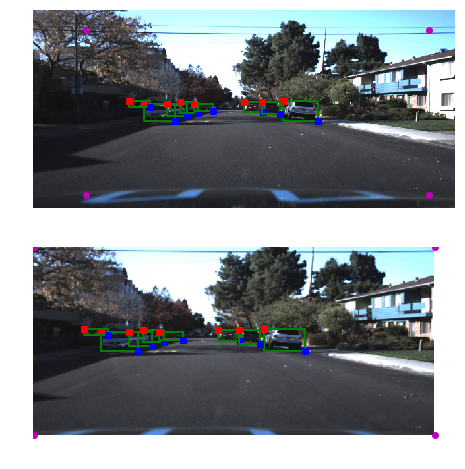

In [6]:
# translation constants
#### Test translation and stretching augmentations

name_str,img,bb_boxes = img_util.get_image_name(df_vehicles, 66388,augmentation=False,trans_range=0,scale_range=0)
img_mask = img_util.get_mask_seg(img,bb_boxes)

tr_x1 = 80
tr_y1 = 30
tr_x2 = 40
tr_y2 = 20


p1 = (tr_x1,tr_y1)
p2 = (img.shape[1]-tr_x2,tr_y1)

p3 = (img.shape[1]-tr_x2,img.shape[0]-tr_y2)
p4 = (tr_x1,img.shape[0]-tr_y2)

pts1 = np.float32([[p1[0],p1[1]],
                   [p2[0],p2[1]],
                   [p3[0],p3[1]],
                   [p4[0],p4[1]]])
pts2 = np.float32([[0,0],
                   [img.shape[1],0],
                   [img.shape[1],img.shape[0]],[0,img.shape[0]]])

M = cv2.getPerspectiveTransform(pts1,pts2)
dst = cv2.warpPerspective(img,M,(img.shape[1],img.shape[0]))
dst = np.array(dst,dtype=np.uint8)


plt.figure(figsize=(12,8))
plt.subplot(2, 1, 1)
plt.imshow(img)
plt.plot(p1[0],p1[1],'mo')
plt.plot(p2[0],p2[1],'mo')
plt.plot(p3[0],p3[1],'mo')
plt.plot(p4[0],p4[1],'mo')

for i in range(len(bb_boxes)):
    img_util.plot_bbox(bb_boxes,i,'g')

    bb_box_i = [bb_boxes.iloc[i]['xmin'],bb_boxes.iloc[i]['ymin'],
                bb_boxes.iloc[i]['xmax'],bb_boxes.iloc[i]['ymax']]
    plt.plot(bb_box_i[0],bb_box_i[1],'rs')
    plt.plot(bb_box_i[2],bb_box_i[3],'bs')
    
plt.axis('off')
plt.subplot(2, 1, 2)
plt.imshow(dst)
bb_boxes1 = bb_boxes.copy(deep=True)
bb_boxes1['xmin'] = (bb_boxes['xmin'] - p1[0])/(p2[0]-p1[0])*img.shape[1]
bb_boxes1['xmax'] = (bb_boxes['xmax'] - p1[0])/(p2[0]-p1[0])*img.shape[1]
bb_boxes1['ymin'] = (bb_boxes['ymin'] - p1[1])/(p3[1]-p1[1])*img.shape[0]
bb_boxes1['ymax'] = (bb_boxes['ymax'] - p1[1])/(p3[1]-p1[1])*img.shape[0]
plt.plot(0,0,'mo')
plt.plot(img.shape[1],0,'mo')
plt.plot(img.shape[1],img.shape[0],'mo')
plt.plot(0,img.shape[0],'mo')
img_util.plot_image_bbox(dst,bb_boxes1)

plt.axis('off');

## More testing translation and stretching augmentation
In this section, we will test the helper functions for stretching and translation. Once again, all the image util function can be found in the img_util.py file

(300, 640, 1)


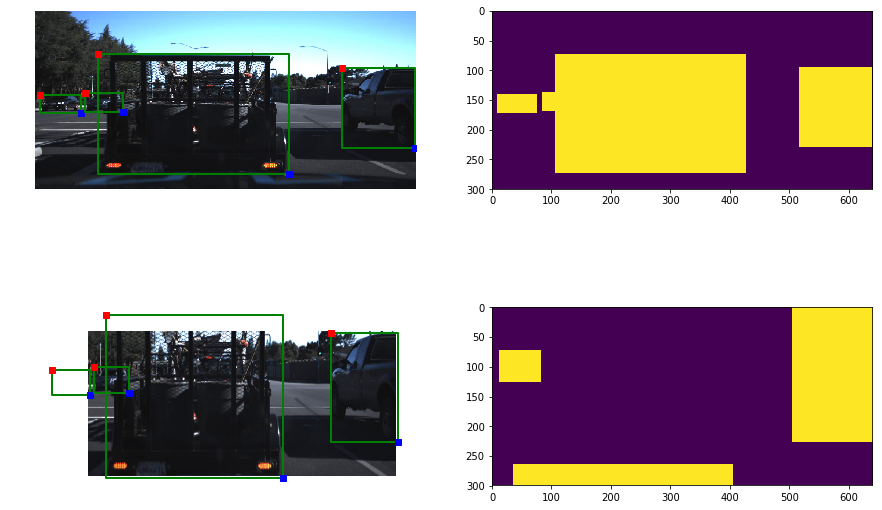

In [7]:
name_str, img, bb_boxes = img_util.get_image_name(df_vehicles,7623, augmentation=False)
img_mask = img_util.get_mask_seg(img, bb_boxes)

print(img_mask.shape)

# plot the image with bounding boxes
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
img_util.plot_image_bbox(img, bb_boxes)

# plot the mask
plt.subplot(2, 2, 2)
plt.imshow(img_mask[:, :, 0])

plt.subplot(2, 2, 3)
dst, bb_boxes1 = img_util.stretch_image(img, bb_boxes, 100)

plt.imshow(dst)

img_util.plot_image_bbox(dst,bb_boxes1)

plt.subplot(2,2,4)
img_mask2 = img_util.get_mask_seg(dst,bb_boxes1)
plt.imshow(img_mask2[:, :, 0]);

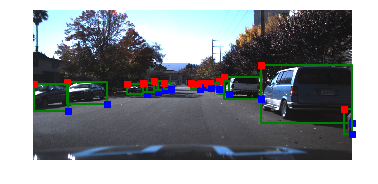

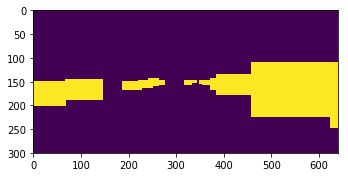

In [8]:
name_str, img, bb_boxes = img_util.get_image_name(df_vehicles, 100, augmentation=False)
img_mask = img_util.get_mask_seg(img, bb_boxes)

# show the bounding boxes of the vehicles
img_util.plot_image_bbox(img, bb_boxes)
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.imshow(img_mask[:, :, 0])

### Training generator, generate augmented images

(66389, 7)


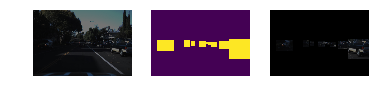

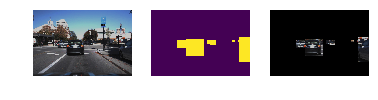

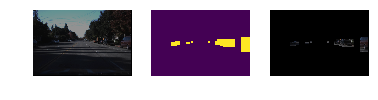

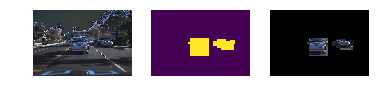

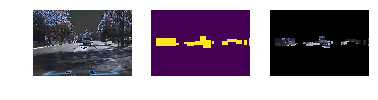

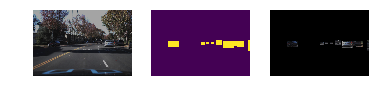

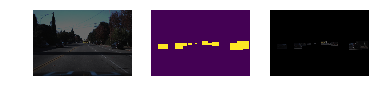

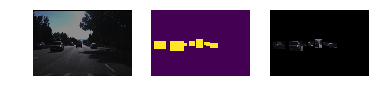

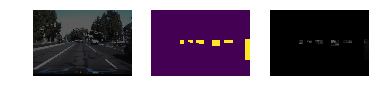

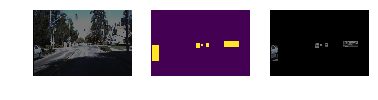

In [15]:
##### Image size,

print(df_vehicles.shape)
training_gen = train_util.generate_train_batch(df_vehicles, 10)
batch_img, batch_mask = next(training_gen)

### Plotting generator output
for i in range(10):
    im = np.array(batch_img[i],dtype=np.uint8)
    im_mask = np.array(batch_mask[i],dtype=np.uint8)
    plt.subplot(1,3,1)
    plt.imshow(im)
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(im_mask[:,:,0])
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(cv2.bitwise_and(im,im,mask=im_mask));
    plt.axis('off')
    plt.show();

# Finally let's build a neural network
It's time to build a convolutional neural network

In [5]:
### IOU or dice coeff calculation
smooth = 1.
def IOU_calc(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)

    return 2*(intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def IOU_calc_loss(y_true, y_pred):
    return -IOU_calc(y_true, y_pred)

In [12]:
model = m.fcn_model()
model.compile(optimizer=Adam(lr=1e-4), loss="sparse_categorical_crossentropy")

/Users/yongyangnie/Documents/Developer/ALVNS/vehicle_object_detection/model.py:35: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  up6 = merge([UpSampling2D(size=(2, 2))(conv5), conv4], mode='concat', concat_axis=3)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/keras/legacy/layers.py:458: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/Users/yongyangnie/Documents/Developer/ALVNS/vehicle_object_detection/model.py:39: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  up7 = merge([UpSampling2D(size=(2, 2))(conv6), conv3], mode='concat', concat_axis=3)
/Users/yongyangnie/Documents/Developer/ALVNS/vehicle_object_d

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 640, 960, 3)   0                                            
____________________________________________________________________________________________________
conv2d_39 (Conv2D)               (None, 640, 960, 8)   224         input_3[0][0]                    
____________________________________________________________________________________________________
conv2d_40 (Conv2D)               (None, 640, 960, 8)   584         conv2d_39[0][0]                  
____________________________________________________________________________________________________
max_pooling2d_9 (MaxPooling2D)   (None, 320, 480, 8)   0           conv2d_40[0][0]                  
___________________________________________________________________________________________

/Users/yongyangnie/Documents/Developer/ALVNS/vehicle_object_detection/model.py:47: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  up9 = merge([UpSampling2D(size=(2, 2))(conv8), conv1], mode='concat', concat_axis=3)
/Users/yongyangnie/Documents/Developer/ALVNS/vehicle_object_detection/model.py:53: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`
  model = Model(input=inputs, output=conv10)


In [14]:
training_gen = training_util.generate_train_batch(df_vehicles,1)

history = model.fit_generator(training_gen, steps_per_epoch=1200, epochs=2, verbose=1, callbacks=None, validation_data=None)

Epoch 1/2


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [ ]:
model.save('train-1.h5')

In [6]:
fcn = m.fcn_model()
print(fcn)
fcn.load_weights("./train-1.h5")
fcn.compile(optimizer=Adam(lr=1e-4), loss=IOU_calc_loss, metrics=[IOU_calc])
print(fcn)

/Users/yongyangnie/Documents/Developer/ALVNS/vehicle_object_detection/model.py:35: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  up6 = merge([UpSampling2D(size=(2, 2))(conv5), conv4], mode='concat', concat_axis=3)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/keras/legacy/layers.py:458: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/Users/yongyangnie/Documents/Developer/ALVNS/vehicle_object_detection/model.py:39: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  up7 = merge([UpSampling2D(size=(2, 2))(conv6), conv3], mode='concat', concat_axis=3)
/Users/yongyangnie/Documents/Developer/ALVNS/vehicle_object_d

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 640, 960, 3)   0                                            
____________________________________________________________________________________________________
conv2d_20 (Conv2D)               (None, 640, 960, 8)   224         input_2[0][0]                    
____________________________________________________________________________________________________
conv2d_21 (Conv2D)               (None, 640, 960, 8)   584         conv2d_20[0][0]                  
____________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)   (None, 320, 480, 8)   0           conv2d_21[0][0]                  
___________________________________________________________________________________________

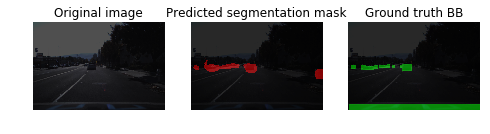

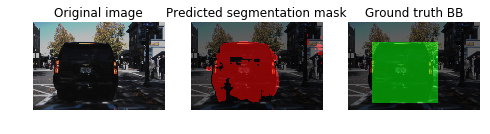

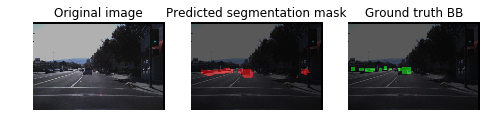

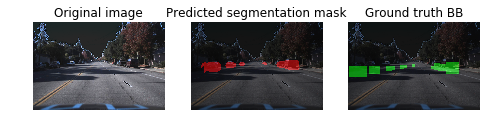

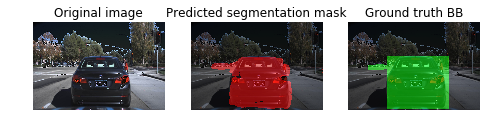

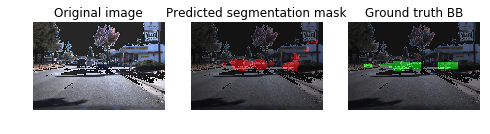

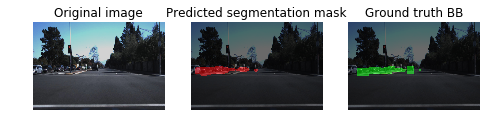

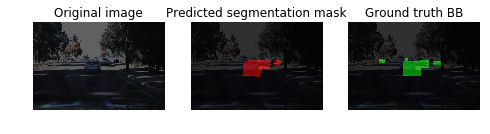

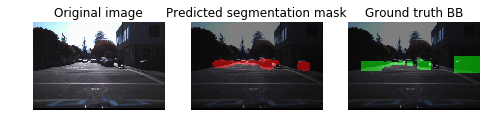

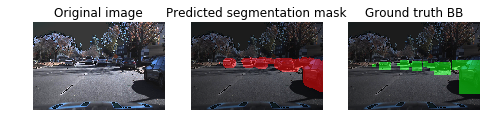

In [18]:
### Test on last frames of data

batch_img,batch_mask = next(training_gen)
pred_all= fcn.predict(batch_img)
np.shape(pred_all)

for i in range(10):

    im = np.array(batch_img[i],dtype=np.uint8)
    im_mask = np.array(255*batch_mask[i],dtype=np.uint8)
    im_pred = np.array(255*pred_all[i],dtype=np.uint8)

    rgb_mask_pred = cv2.cvtColor(im_pred,cv2.COLOR_GRAY2RGB)
    rgb_mask_pred[:,:,1:3] = 0*rgb_mask_pred[:,:,1:2]
    rgb_mask_true= cv2.cvtColor(im_mask,cv2.COLOR_GRAY2RGB)
    rgb_mask_true[:,:,0] = 0*rgb_mask_true[:,:,0]
    rgb_mask_true[:,:,2] = 0*rgb_mask_true[:,:,2]

    img_pred = cv2.addWeighted(rgb_mask_pred,0.5,im,0.5,0)
    img_true = cv2.addWeighted(rgb_mask_true,0.5,im,0.5,0)

    plt.figure(figsize=(8,3))
    plt.subplot(1,3,1)
    plt.imshow(im)
    plt.title('Original image')
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(img_pred)
    plt.title('Predicted segmentation mask')
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(img_true)
    plt.title('Ground truth BB')
    plt.axis('off')
    plt.show()

In [17]:
#### Function for drawing bounding boxes, taken from Ryan's code on Udacity
img_rows = 640
img_cols = 960

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        if ((np.max(nonzeroy)-np.min(nonzeroy)>50) & (np.max(nonzerox)-np.min(nonzerox)>50)):
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            # Draw the box on the image       
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255),6)
    # Return the image
    return img

def test_new_img(img):
    img = cv2.resize(img,(img_cols, img_rows))
    img = np.array([img])
    pred = fcn.predict(img)
    return pred,img[0]

def get_BB_new_img(img):
    # Take in RGB image
    pred,img = test_new_img(img)
    img  = np.array(img,dtype= np.uint8)
    img_pred = np.array(255*pred[0],dtype=np.uint8)
    heatmap = img_pred[:,:,0]
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

### Test on new image

In [18]:
### Test on new image

test_img = '/Users/yongyangnie/Documents/Developer/ALVNS/vehicle_object_detection/test_images/test1.jpg'
im = cv2.imread(test_img)
im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
draw_img = get_BB_new_img(im)

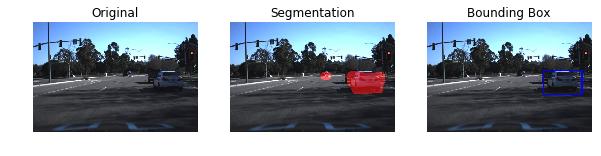

In [20]:
draw_img = get_BB_new_img(im)
im = cv2.imread(test_img)
im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
pred,im = test_new_img(im)
im  = np.array(im,dtype= np.uint8)
im_pred = np.array(255*pred[0],dtype=np.uint8)
rgb_mask_pred = cv2.cvtColor(im_pred,cv2.COLOR_GRAY2RGB)
rgb_mask_pred[:,:,1:3] = 0*rgb_mask_pred[:,:,1:2]

img_pred = cv2.addWeighted(rgb_mask_pred,0.55,im,1,0)

draw_img = get_BB_new_img(im)

plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
plt.imshow(im)
plt.title('Original')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(img_pred)
plt.title('Segmentation')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(draw_img)
plt.title('Bounding Box')
plt.axis('off');